In [1]:
import cv2 as cv
from PIL import Image
from PIL import ImageDraw, ImageFilter, ImageFont
import glob
import os
import shutil
import pandas as pd
import textwrap

In [2]:
def getMultilineSize(text, init_width, init_font_size, upper_left_bound, font_style = 'fonts/Montserrat-SemiBold.otf', line_height_ratio = 6):
    text_list = textwrap.TextWrapper(width=init_width).wrap(text =text)
    text_formatted = ''
    for w in text_list[:-1]:
        text_formatted = text_formatted + w + '\n' # add line break
    text_formatted+= text_list[-1] # add the last word

    my_font=ImageFont.truetype(font_style, init_font_size)
    w, h = draw.multiline_textsize(
        text = text_formatted,
        spacing = init_font_size/line_height_ratio,
        font = my_font
    )
    return (w, h, text_formatted)

def writeMultiline(draw, text, init_font_size=10, max_width=1400, max_height=400, upper_left_bound= (145, 187), font_style='fonts/Montserrat-SemiBold.otf', color = '#000000' ):
    # get initial value
    init_width = max(len(x) for x in text.split()) # must be at least the length of the longest word in the text
    w, h, text_formatted= getMultilineSize(text, init_width, init_font_size, upper_left_bound)

    # resize
    while w< max_width:
        init_font_size +=1
        my_font=ImageFont.truetype(font_style, init_font_size)
        w, h, text_formatted = getMultilineSize(text, init_width, init_font_size, upper_left_bound)
        while h>=max_height:
            init_width +=1
            w, h, text_formatted = getMultilineSize(text, init_width, init_font_size, upper_left_bound)
            if w >= max_width:
                break
        while h < max_height:
            init_width -=1
            w, h, text_formatted = getMultilineSize(text, init_width, init_font_size, upper_left_bound)
            if w >= max_width:
                break

    # do some minor adjustments
    while w > max_width or h>max_height:
        init_font_size -=1
        w, h, text_formatted = getMultilineSize(text, init_width, init_font_size, upper_left_bound)

    # draw text
    text_list = textwrap.TextWrapper(width=init_width).wrap(text =text)
    text_formatted = ''
    for word in text_list[:-1]:
        text_formatted = text_formatted + word + '\n' # add line break
    text_formatted+= text_list[-1] # add the last word

    my_font=ImageFont.truetype(font_style, init_font_size)
    draw.multiline_text(
        upper_left_bound,
        spacing = init_font_size/6,
        text = text_formatted,
        font = my_font,
        fill=color
    )

    return (init_width, init_font_size, w, h)

In [3]:
def getSingleLineSize(draw, text, max_width, font_size, font_style):
    myFont=ImageFont.truetype(font_style, font_size)
    w, h=draw.textsize(text, font=myFont)

    if w > max_width:
        while w > max_width:
            font_size-=1
            myFont=ImageFont.truetype(font_style, font_size)
            w, h=draw.textsize(text, font=myFont)
    else:
        pass

    return (w, h, myFont)

def writeSingleLine(draw, text, box, max_width, font_size=1, align='left', font_style='fonts/Montserrat-SemiBold.otf', color = '#000000'):

    #Dynamically optimize font size to fit in the bounding box for name
    w, h, myFont=getSingleLineSize(draw, text, max_width, font_size, font_style)

    #Add text with optimized font size
    if align =='center':
        #Coordinates of bounding box of name area
        x1, y1, x2, y2=box
        draw.text([(x1+x2-w)/2, (y1+y2-h)/2],text,
                    align='left',
                    fill=color, font=myFont)
    elif align == 'left':
        #Coordinates of bounding box of name area
        x1, y1=box
        draw.text([x1, y1],text,
                    align='left',
                    fill=color, font=myFont)

In [4]:
# provide template
template_path = 'template/2021 NEW Year Postcard - 4x6 PostCard-Back-01.png'

# create image objects
image = Image.open(template_path)

# load data
#df = pd.read_excel('data/template.xlsx', sheet_name='Sheet1')
df = pd.read_excel('data/US contacts.xlsx', sheet_name='Sheet1',header=None)
df.columns=['name', 'address']
df.head()

,name,address
0,Audrey Jia,PO box 341093 20827 Bethesda MD
1,An Song,"795 San Antonio Road, Palo Alto, CA 94303"
2,Catherine X. Pan-Giordano,"Dorsey & Whitney LLP, 51 West 52nd Street, New..."
3,Chen Webin,"Waters Corporation, 34 Maple Street, Milford, ..."
4,Cheng Liu,"5858 Horton St #170, Emeryville, CA 94608"


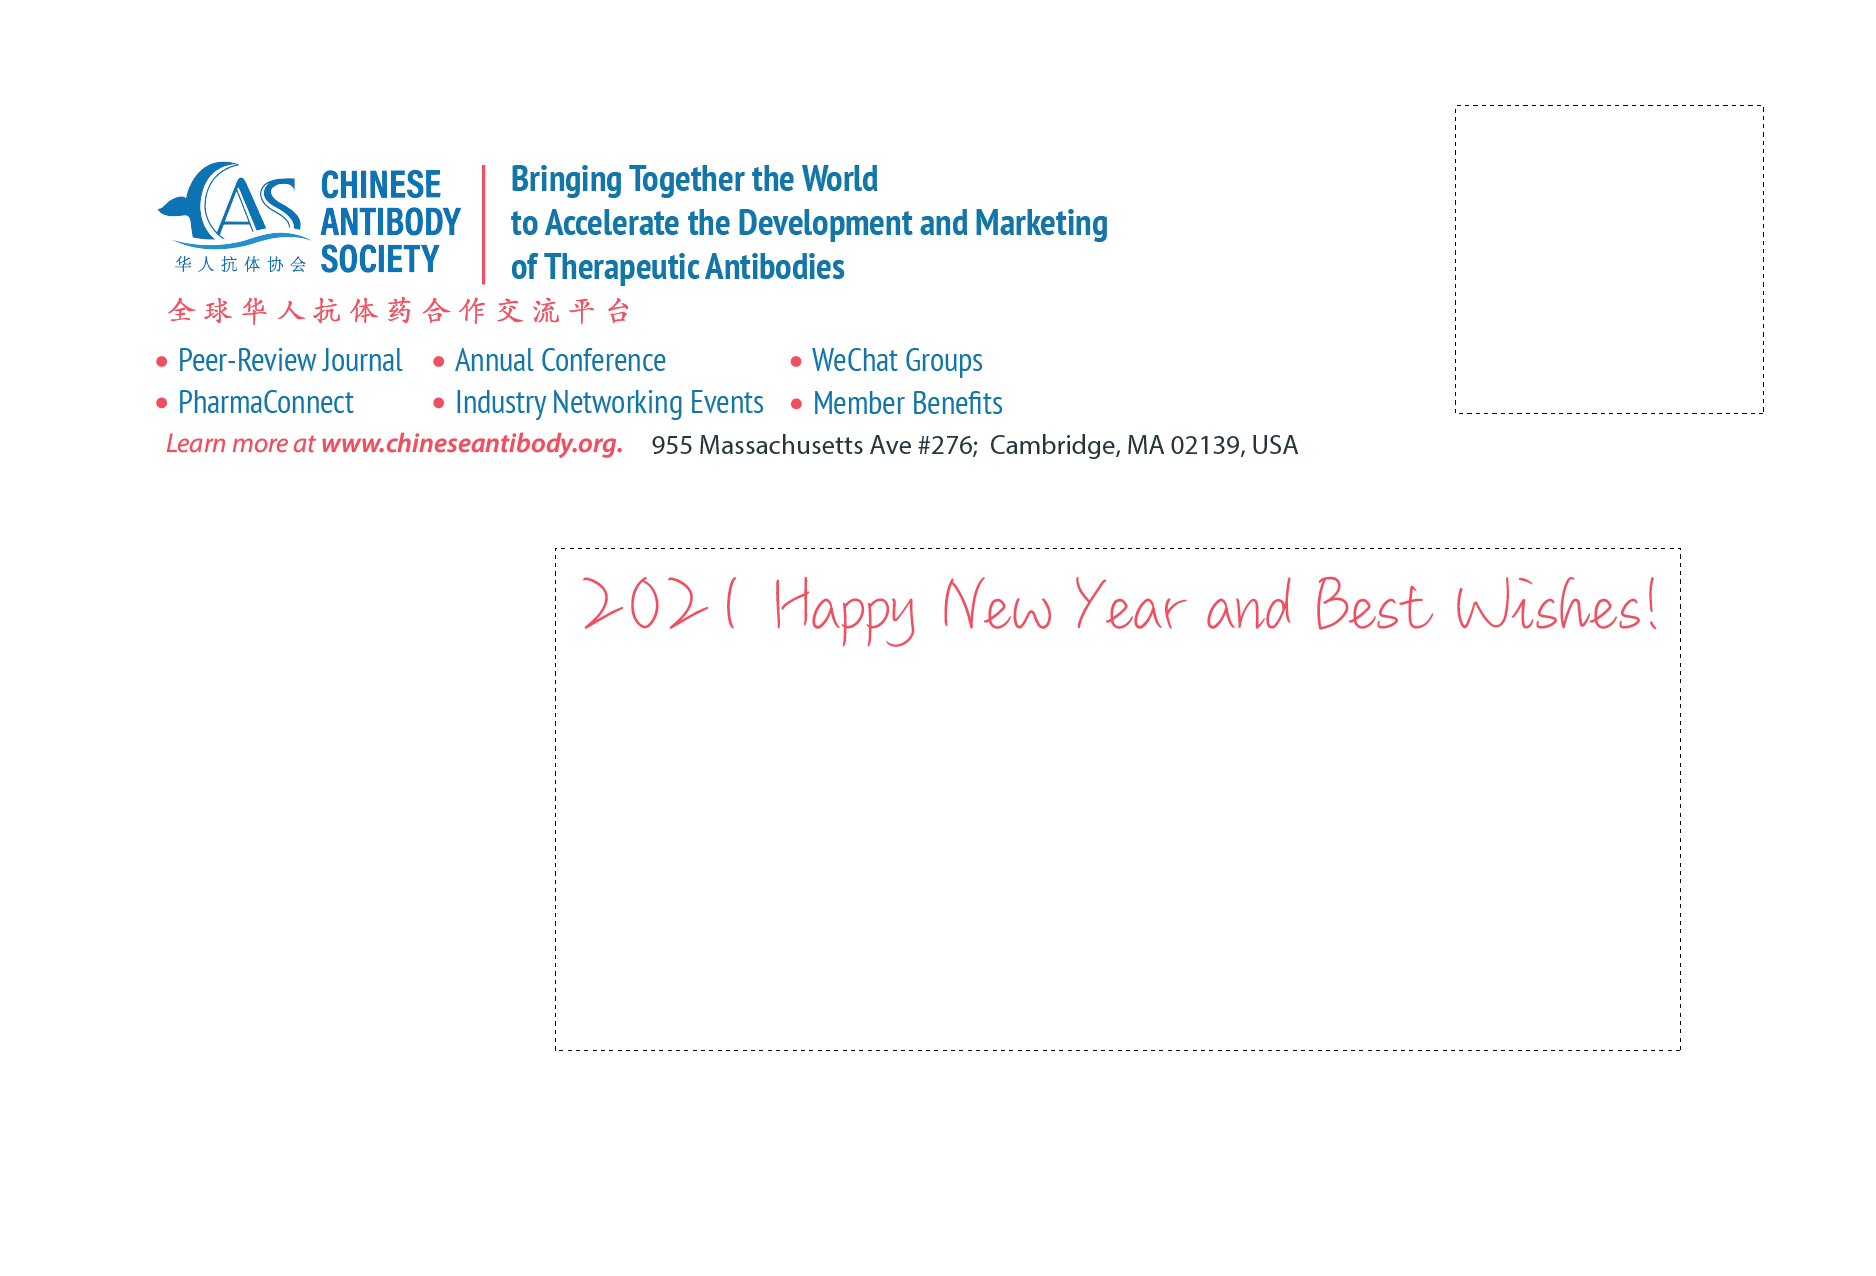

In [5]:
# image size: 6x4 inch, 1876x1276 px （x scale: 314, y scale: 319)
image

In [6]:
# image size in inches
x = 6
y = 4
# scale factor
x_scale, y_scale = int(image.size[0]/x), int(image.size[1]/y)

## Write
When using different fonts, adjust `max_w` in `writeSingleLine()` function, and `max_width`, `max_height` in `writeMultiline()` function.

## English

In [7]:
# English
font = 'fonts/YangRenDongZhuShiTi-Light-2.ttf'

for idx, row in df.iterrows():
    image_cp = image.copy()
    draw=ImageDraw.Draw(image_cp)

    writeSingleLine(
        draw, row['name'].strip(), box=[2*x_scale, 2.3*y_scale], font_size=80, max_width = 500, align = 'left', font_style= font) # init font_size with 80
    writeMultiline(
        draw, row['address'].strip(), max_width=1200, max_height=130, upper_left_bound=[2*x_scale, 2.6*y_scale], font_style=font)

    image_cp.save('result/usa/'+str(idx)+'-'+ row['name']+'.png')


## Chinese

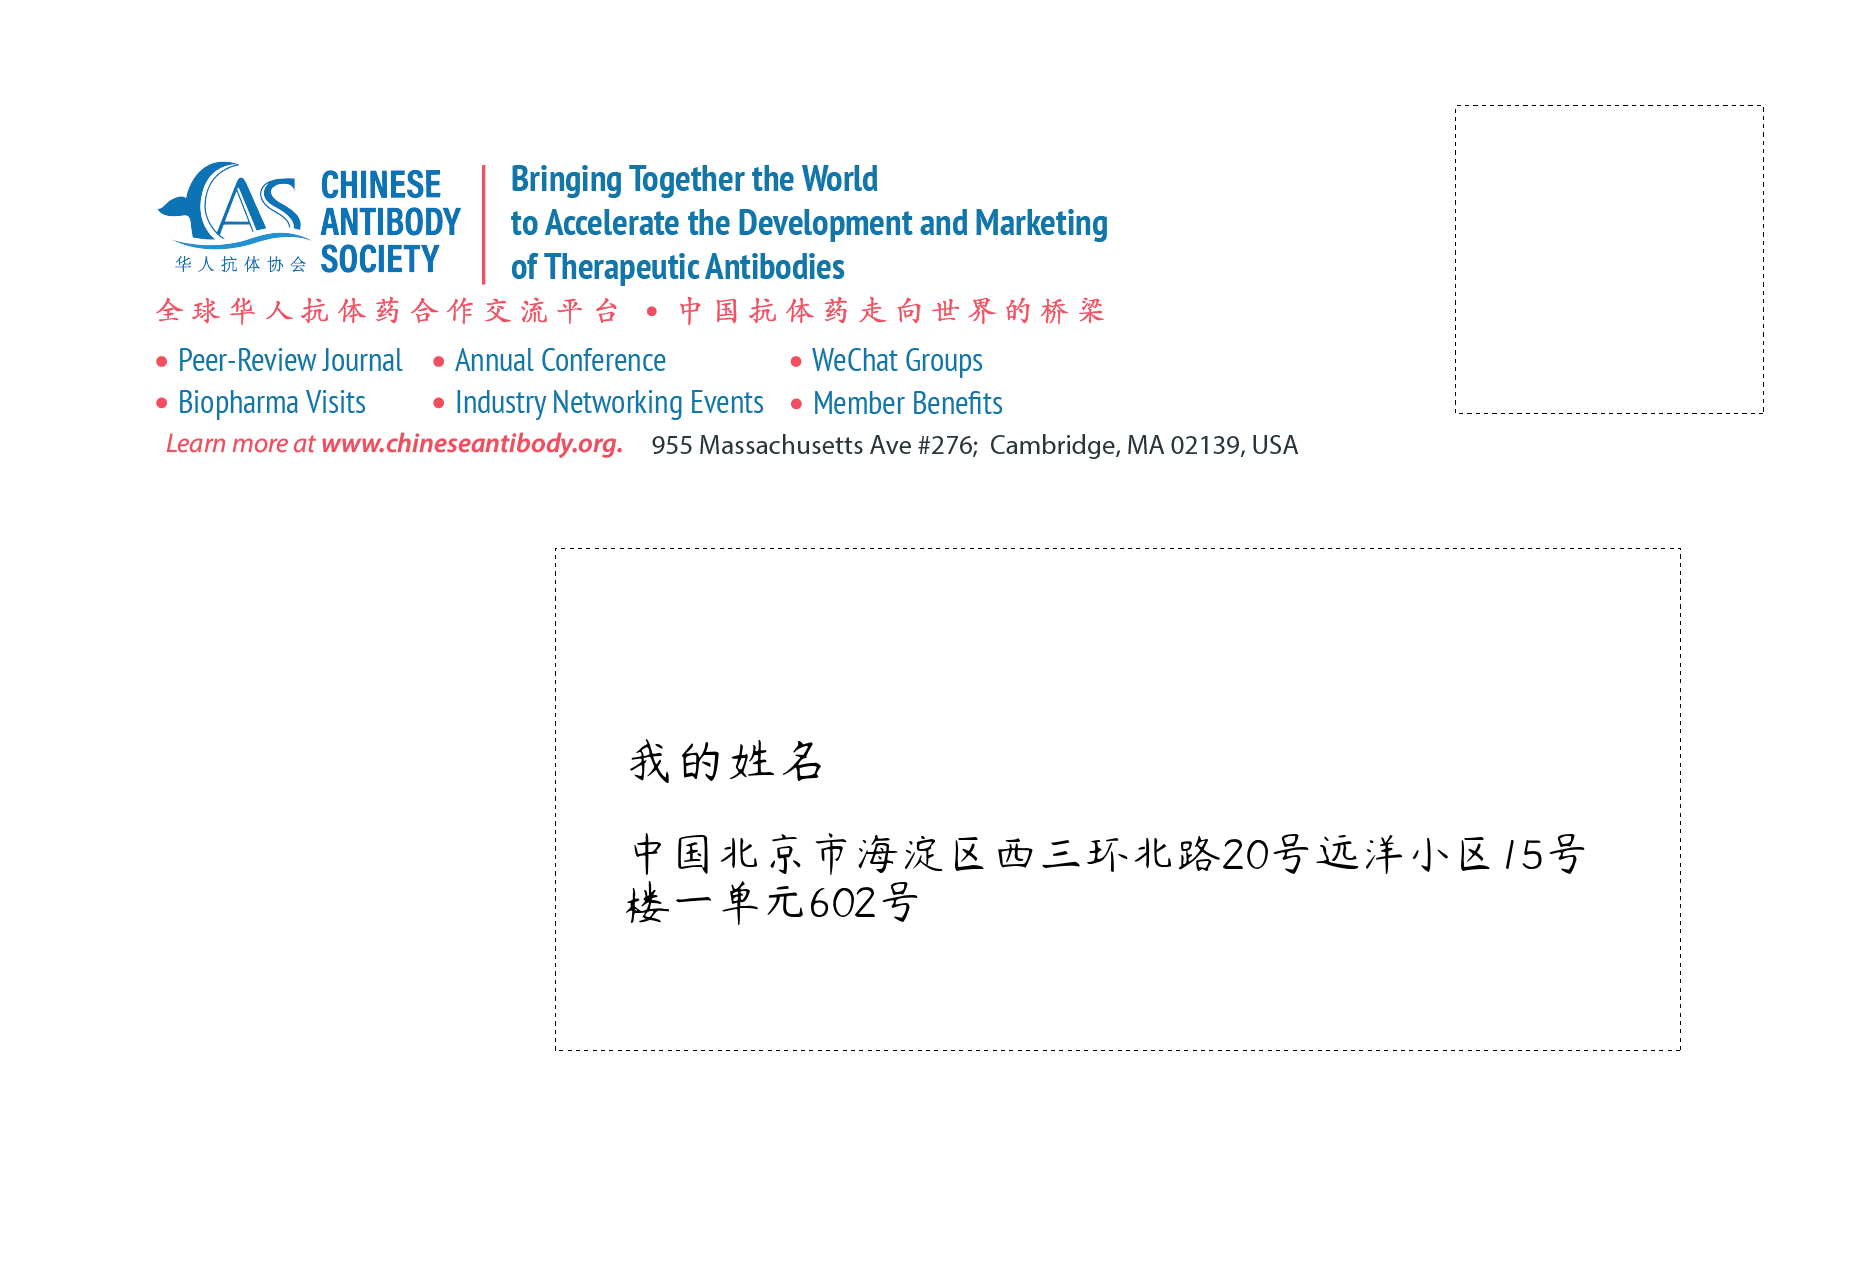

In [200]:
# chinese
image_cp = image.copy()
draw=ImageDraw.Draw(image_cp)
writeSingleLine(
    draw, df.Name[2].strip(), box=[2*x_scale, 2.3*y_scale], max_w = 200, align = 'left', font_style='fonts/YangRenDongZhuShiTi-Light-2.ttf')

writeMultiline(
    draw, df.Address[2].strip(), max_width=620, max_height=100, upper_left_bound=[2*x_scale, 2.6*y_scale], font_style='fonts/YangRenDongZhuShiTi-Light-2.ttf')

image_cp

In [61]:
df.Address[1]

'578 Science Drive, Boston, MA, USA. 27705'